# Density Functional Theory python examples


I'll add more info soon, for now here it is, shortly:

This follows the assignments for lectures of Thomas Arias, lectures available on youtube. You'll find info and an embedded video of the first lecture in the DFT Quantum Dot page on the Computational Physics Blog: https://compphys.go.ro/dft-for-a-quantum-dot/

The following links are available on the page mentioned above, but I'll repeat them here:

Assignments are described here: https://drive.google.com/drive/folders/0B8lnMKudhQYMd2NWTkV1akpYSTQ?hl=en

A paper that describes the formalism: https://arxiv.org/abs/cond-mat/9909130

For now this is work in progress, I'll add more to it (including comments), hopefully it will cover at least as much as the https://github.com/aromanro/DFTQuantumDot project.

### The Poisson Equation

This corresponds to the first assigment and it covers what the https://github.com/aromanro/Poisson project covers (described here: https://compphys.go.ro/solving-poisson-equation/).

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
S = np.array([32, 32, 32])
ms = np.arange(np.prod(S))
m1 = np.remainder(ms, S[0])
m2 = np.remainder(np.floor_divide(ms, S[0]), S[1])
m3 = np.remainder(np.floor_divide(ms, S[0] * S[1]), S[2])
M = np.asarray([m1, m2, m3]).transpose()

In [3]:
n1 = np.array([x - (x > S[0]/2) * S[0] for x in m1])
n2 = np.array([x - (x > S[1]/2) * S[1] for x in m2])
n3 = np.array([x - (x > S[2]/2) * S[2] for x in m3])
N = np.asarray([n1, n2, n3]).transpose()

In [4]:
R=np.diag([6, 6, 6])

In [5]:
r = M @ np.linalg.inv(np.diag(S)) @ np.transpose(R)
G = 2 * m.pi * N @ np.linalg.inv(R)
G2 = np.sum(G * G, axis=1)

In [6]:
cellCenter = np.sum(R, axis = 1) / 2

In [7]:
vecsFromCenter = r - np.ones((np.prod(S), 3)) * cellCenter
dr = np.sqrt(np.sum(vecsFromCenter * vecsFromCenter, 1))

In [8]:
def Gaussian(r, sigma = 0.5):
    twosigma2 = 2. * sigma * sigma
    return np.exp(-r*r/twosigma2) / np.power(np.sqrt(m.pi * twosigma2), 3);    

In [9]:
sigma1 = 0.75
sigma2 = 0.5
g1 = Gaussian(dr, sigma1)
g2 = Gaussian(dr, sigma2)
n = g2 - g1

In [10]:
print ("Normalization check on g1: ", np.sum(g1) * np.linalg.det(R) / np.prod(S))

Normalization check on g1:  0.99979348165842


In [11]:
print ("Normalization check on g2: ", np.sum(g2) * np.linalg.det(R) / np.prod(S))

Normalization check on g2:  0.9999999916978626


In [12]:
print ("Total charge check: ", np.sum(n) * np.linalg.det(R) / np.prod(S))

Total charge check:  0.00020651003944279004


In [13]:
def fft3(dat, N, s):
    if s == 1:
        result = np.reshape(np.fft.ifftn(np.reshape(dat, (N[0], N[1], N[2]))) * np.prod(N), np.size(dat))        
    else:
        result = np.reshape(np.fft.fftn(np.reshape(dat, (N[0], N[1], N[2]))), np.size(dat))
    
    return result

In [14]:
def cI(input):
    return fft3(input, S, 1)

In [15]:
def cJ(input):
    return 1. / np.prod(S) * fft3(input, S, -1)

In [16]:
def O(input):
    return np.linalg.det(R) * input

In [17]:
def L(input):
    return -np.linalg.det(R) * G2 * input

In [18]:
def Linv(input):
    old_settings = np.seterr(divide='ignore', invalid='ignore')
    result = -1. / np.linalg.det(R) * input / G2
    result[0] = 0
    np.seterr(**old_settings)
    return result    

In [19]:
def Poisson(n):
    return cI(Linv(-4. * m.pi * O(cJ(n))))

In [20]:
phi = Poisson(n)

In [21]:
phi = np.real(phi)

In [22]:
Unum = 0.5 * np.real(cJ(phi).transpose().conjugate() @ O(cJ(n)))
Uanal=((1./sigma1+1./sigma2)/2.- np.sqrt(2.) / np.sqrt(sigma1*sigma1 + sigma2*sigma2))/np.sqrt(m.pi)
print('Numeric, analytic Coulomb energy:', Unum, Uanal)

Numeric, analytic Coulomb energy: 0.055140656519275424 0.05514252769473334


In [23]:
def Plot(dat):

    fig=plt.figure(figsize=(25, 15))

    x = np.arange(0, S[1])
    y = np.arange(0, S[2])
    xs, ys = np.meshgrid(x, y)

    toplot1 = np.reshape(dat, S)[:,:,int(S[2]/2)]
        
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(xs, ys, toplot1, cmap='viridis', edgecolor='none')

    x = np.arange(0, S[0])
    xs, ys = np.meshgrid(x, y)

    toplot2 = np.reshape(dat, S)[:,int(S[1]/2),:]
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(xs, ys, toplot2, cmap='viridis', edgecolor='none')

    y = np.arange(0, S[1])
    xs, ys = np.meshgrid(x, y)
    toplot3 = np.reshape(dat, S)[int(S[0]/2),:,:]
    
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(xs, ys, toplot3, cmap='viridis', edgecolor='none')

    plt.tight_layout
    plt.show()

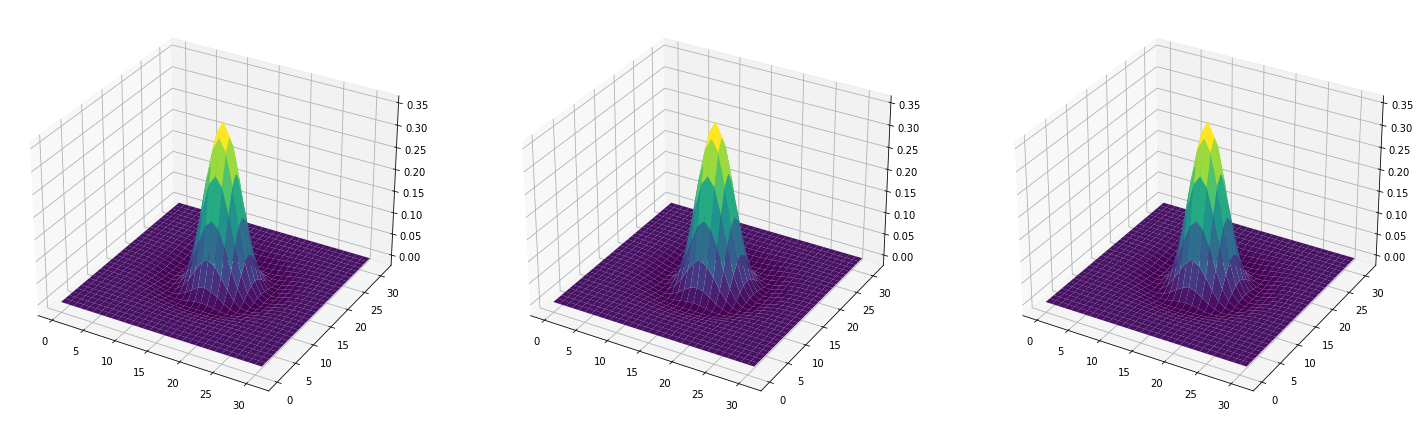

In [24]:
Plot(n)

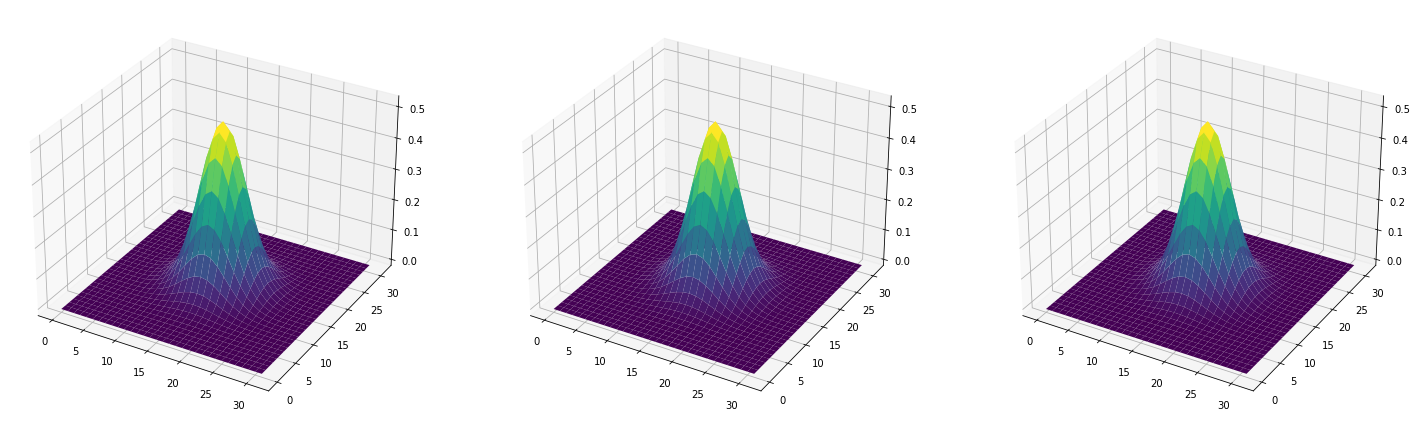

In [25]:
Plot(phi)

In [26]:
X = np.asarray([[0, 0, 0], [1.75, 0, 0]])
Sf = np.sum(np.exp(-1j * G @ X.transpose()), axis = 1)
Z = 1

In [27]:
sigma1 = 0.25
g1 = Z * Gaussian(dr, sigma1)

In [28]:
n = cI(cJ(g1)* Sf)
n = np.real(n)

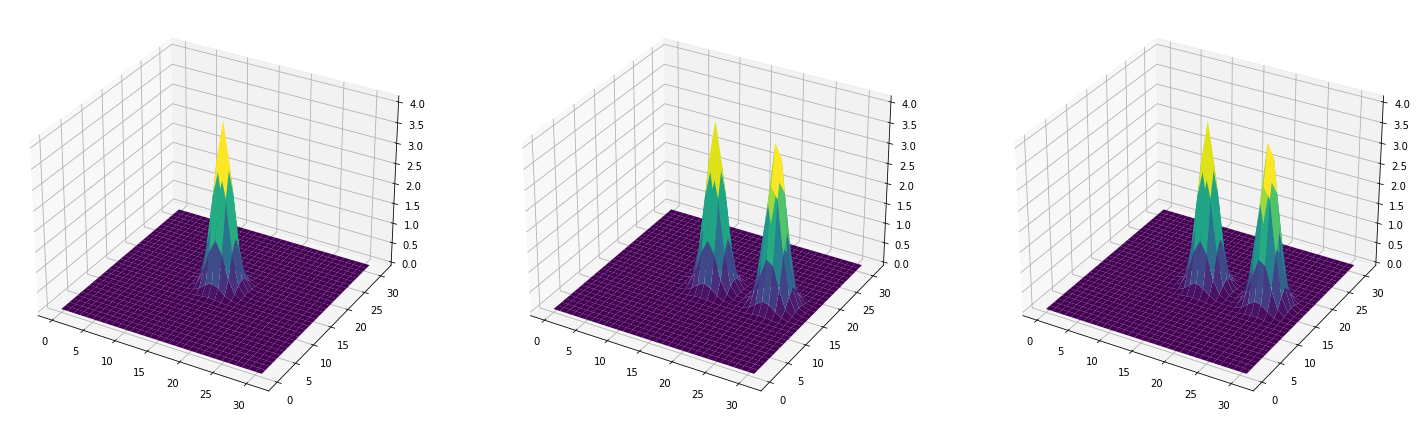

In [29]:
Plot(n)

In [30]:
Uself = Z*Z/(2.*m.sqrt(m.pi))*(1./sigma1)*np.size(X,0)

In [31]:
phi = Poisson(n)
phi = np.real(phi)

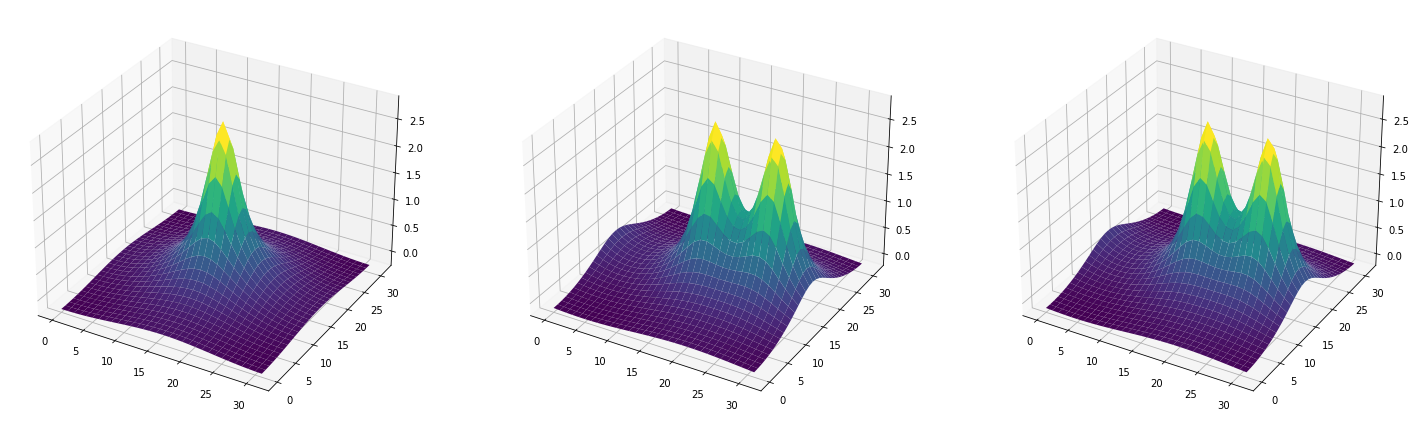

In [32]:
Plot(phi)

In [33]:
Unum = 0.5 * np.real(cJ(phi).transpose().conjugate() @ O(cJ(n)))
print('Ewald energy:', Unum - Uself)
print('Unum:', Unum)
print('Uself:', Uself)

Ewald energy: -0.33353346881958523
Unum: 1.9232248653714399
Uself: 2.256758334191025
